# Tutorial 05 - Regularization

## Cats vs Dogs
From Tutorial 01/03. Dataset can be downloaded from http://files.fast.ai/data/dogscats.zip  
Classification to 2 classes

Colab link: https://colab.research.google.com/drive/1VmlR-9DHET3cgLHuqZVm3U8wzlgf8HHT

In [1]:
# !wget http://files.fast.ai/data/dogscats.zip
# !unzip dogscats.zip

In [2]:
# !pip install -U tqdm

In [3]:
from tqdm.notebook import tqdm
import numpy as np
import torch
import PIL
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize, Compose
root_dir = 'dogscats/train'

target_size = (32, 32)
transforms = Compose([Resize(target_size), # Resizes image
                    ToTensor(),           # Converts to Tensor, scales to [0, 1] float (from [0, 255] int)
                    Normalize(mean=(0.5, 0.5, 0.5,), std=(0.5, 0.5, 0.5)), # scales to [-1.0, 1.0]
                    ])

train_dataset_ = ImageFolder(root_dir, transform=transforms)

In [6]:
len(train_dataset_)

23000

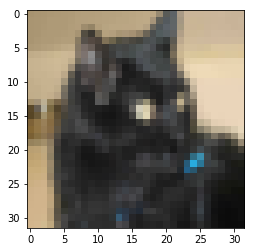

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow((train_dataset_[101][0]*0.5+0.5).numpy().transpose(1, 2, 0))

In [8]:
class RAMDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset):
        data = []
        for sample in tqdm(dataset):
            data.append(sample)
        self.n = len(dataset)
        self.data = data
        
    def __getitem__(self, ind):
        return self.data[ind]
    
    def __len__(self):
        return self.n

train_dataset = RAMDatasetWrapper(train_dataset_)

In [9]:
from torch.utils.data import DataLoader
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=32)

In [10]:
# Same for validation dataset
val_root_dir = 'dogscats/valid'
val_dataset_ = ImageFolder(val_root_dir, transform=transforms)
val_dataset = RAMDatasetWrapper(val_dataset_)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [11]:
print(len(val_dataset))

2000


In [12]:
import torch.nn as nn
    
class MLPModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim):
        super(MLPModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)
        )
    
    def forward(self, input):
        input = input.view(input.size(0), -1)
        return self.layers(input)

In [13]:
import numpy as np

def train_epoch(model, train_dataloader, optimizer, loss_fn):
    losses = []
    correct_predictions = 0
    # Iterate mini batches over training dataset
    for images, labels in tqdm(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        # Run predictions
        output = model(images)
        # Set gradients to zero
        optimizer.zero_grad()
        # Compute loss
        loss = loss_fn(output, labels)
        # Backpropagate (compute gradients)
        loss.backward()
        # Make an optimization step (update parameters)
        optimizer.step()
        # Log metrics
        losses.append(loss.item())
        predicted_labels = output.argmax(dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()
    accuracy = 100.0 * correct_predictions / len(train_dataloader.dataset)
    # Return loss values for each iteration and accuracy
    mean_loss = np.array(losses).mean()
    return mean_loss, accuracy

def evaluate(model, dataloader, loss_fn):
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            # Run predictions
            output = model(images)
            # Compute loss
            loss = loss_fn(output, labels)
            # Save metrics
            predicted_labels = output.argmax(dim=1)
            correct_predictions += (predicted_labels == labels).sum().item()
            losses.append(loss.item())
    mean_loss = np.array(losses).mean()
    accuracy = 100.0 * correct_predictions / len(dataloader.dataset)
    # Return mean loss and accuracy
    return mean_loss, accuracy

def train(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_function):
    # We will monitor loss functions as the training progresses
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(n_epochs):
        model.train()
        train_loss, train_accuracy = train_epoch(model, train_dataloader, optimizer, loss_fn)
        model.eval()
        val_loss, val_accuracy = evaluate(model, val_dataloader, loss_fn)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        print('Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                      train_losses[-1],
                                                                                                      train_accuracies[-1],
                                                                                                      val_losses[-1],
                                                                                                      val_accuracies[-1]))
    return train_losses, val_losses, train_accuracies, val_accuracies

In [14]:
def plot(train_losses, val_losses, train_accuracies, val_accuracies, title):
    plt.figure()
    plt.plot(np.arange(len(train_losses)), train_losses)
    plt.plot(np.arange(len(val_losses)), val_losses)
    plt.legend(['train_loss', 'val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('loss value')
    plt.title('{}: Train/val loss'.format(title));

    plt.figure()
    plt.plot(np.arange(len(train_accuracies)), train_accuracies)
    plt.plot(np.arange(len(val_accuracies)), val_accuracies)
    plt.legend(['train_acc', 'val_acc'])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('{}: Train/val accuracy'.format(title));

In [39]:
model = MLPModel(32*32*3, 128)
model = model.to(device)
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
n_epochs = 25
loss_fn = nn.CrossEntropyLoss()

In [40]:
train_losses, val_losses, train_acc, val_acc = train(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_fn)


Epoch 1/25: train_loss: 0.6517, train_accuracy: 60.5652, val_loss: 0.6366, val_accuracy: 62.0500



Epoch 2/25: train_loss: 0.6190, train_accuracy: 65.2087, val_loss: 0.6294, val_accuracy: 64.4000



Epoch 3/25: train_loss: 0.5980, train_accuracy: 67.3696, val_loss: 0.6080, val_accuracy: 64.7000



Epoch 4/25: train_loss: 0.5806, train_accuracy: 68.7739, val_loss: 0.6132, val_accuracy: 67.0500



Epoch 5/25: train_loss: 0.5625, train_accuracy: 70.6087, val_loss: 0.6246, val_accuracy: 66.0000



Epoch 6/25: train_loss: 0.5456, train_accuracy: 71.8478, val_loss: 0.6201, val_accuracy: 67.4000



Epoch 7/25: train_loss: 0.5256, train_accuracy: 73.1652, val_loss: 0.6399, val_accuracy: 66.5500



Epoch 8/25: train_loss: 0.5064, train_accuracy: 74.5174, val_loss: 0.6243, val_accuracy: 66.9500



Epoch 9/25: train_loss: 0.4889, train_accuracy: 75.7087, val_loss: 0.6230, val_accuracy: 66.3500



Epoch 10/25: train_loss: 0.4683, train_accuracy: 77.2000, val_loss: 0.6695, val_accuracy: 64.3000



Epoch 11/25: train_loss: 0.4502, train_accuracy: 78.1304, val_loss: 0.6699, val_accuracy: 64.6000



Epoch 12/25: train_loss: 0.4292, train_accuracy: 79.4043, val_loss: 0.7228, val_accuracy: 65.8000



Epoch 13/25: train_loss: 0.4077, train_accuracy: 80.5652, val_loss: 0.7554, val_accuracy: 65.4000



Epoch 14/25: train_loss: 0.3940, train_accuracy: 81.5261, val_loss: 0.7181, val_accuracy: 66.8500



Epoch 15/25: train_loss: 0.3737, train_accuracy: 82.6783, val_loss: 0.7513, val_accuracy: 65.9500



Epoch 16/25: train_loss: 0.3493, train_accuracy: 83.9261, val_loss: 0.8531, val_accuracy: 65.6500



Epoch 17/25: train_loss: 0.3365, train_accuracy: 84.8217, val_loss: 0.8169, val_accuracy: 65.1000



Epoch 18/25: train_loss: 0.3104, train_accuracy: 85.9348, val_loss: 0.8797, val_accuracy: 65.6000



Epoch 19/25: train_loss: 0.2939, train_accuracy: 86.8522, val_loss: 0.9806, val_accuracy: 65.5000



Epoch 20/25: train_loss: 0.2808, train_accuracy: 87.6043, val_loss: 0.9416, val_accuracy: 66.1000



Epoch 21/25: train_loss: 0.2630, train_accuracy: 88.4000, val_loss: 1.0501, val_accuracy: 66.1500



Epoch 22/25: train_loss: 0.2500, train_accuracy: 89.2000, val_loss: 1.0482, val_accuracy: 64.6500



Epoch 23/25: train_loss: 0.2334, train_accuracy: 90.1435, val_loss: 1.1165, val_accuracy: 65.0500



Epoch 24/25: train_loss: 0.2195, train_accuracy: 90.5957, val_loss: 1.2345, val_accuracy: 64.8000



Epoch 25/25: train_loss: 0.2122, train_accuracy: 91.0652, val_loss: 1.1880, val_accuracy: 66.2000


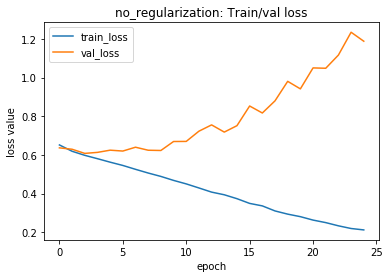

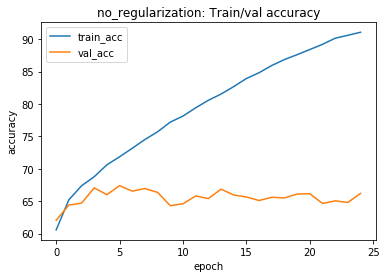

In [41]:
plot(train_losses, val_losses, train_acc, val_acc, title='no_regularization')

In [42]:
val_accuracy_no_regularization = val_acc[-1]
val_loss_no_regularization = val_losses[-1]
print('No regularization. Validation loss: {:.4f}, validation accuracy: {:.4f}'.format(val_loss_no_regularization, val_accuracy_no_regularization))

No regularization. Validation loss: 1.1880, validation accuracy: 66.2000


# Early stopping
We will monitor **val_loss** and save the model with the lowest value.  
We could also stop the training if the validation loss stops decreasing

In [19]:
model = MLPModel(32*32*3, 128)
model = model.to(device)
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
n_epochs = 25
loss_fn = nn.CrossEntropyLoss()

In [20]:
from copy import deepcopy

def train_early_stopping(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_function):
    # We will monitor loss functions as the training progresses
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    ### EARLY STOPPING INITIALIZATION
    best_val_loss = np.inf
    best_model = None
    patience = 5 # if no improvement after 5 epochs, stop training
    counter = 0
    ###

    for epoch in range(n_epochs):
        model.train()
        train_loss, train_accuracy = train_epoch(model, train_dataloader, optimizer, loss_fn)
        model.eval()
        val_loss, val_accuracy = evaluate(model, val_dataloader, loss_fn)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        print('Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                      train_losses[-1],
                                                                                                      train_accuracies[-1],
                                                                                                      val_losses[-1],
                                                                                                      val_accuracies[-1]))
    
        ### EARLY STOPPING CODE
        if val_loss < best_val_loss: # If validation loss improved, save the model and reset the counter
            best_val_loss = val_loss
            best_model = deepcopy(model)
            counter = 0
        else: # If validation loss not improved, increase the counter
            counter += 1
        if counter == patience: # If no improvement for some number of epochs, stop training
            print('No improvement for {} epochs; training stopped.'.format(patience))
            break
    # Copy best model parameters to model
    for param1, param2 in zip(model.parameters(), best_model.parameters()):
        param1.data = param2.data
    ###
    return train_losses, val_losses, train_accuracies, val_accuracies

In [21]:
model = MLPModel(32*32*3, 64)
model = model.to(device)
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
n_epochs = 25
loss_function = nn.CrossEntropyLoss()

train_losses_es, val_losses_es, train_acc_es, val_acc_es = train_early_stopping(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_fn)


Epoch 1/25: train_loss: 0.6550, train_accuracy: 60.5348, val_loss: 0.6358, val_accuracy: 62.8000



Epoch 2/25: train_loss: 0.6195, train_accuracy: 65.1565, val_loss: 0.6259, val_accuracy: 64.5500



Epoch 3/25: train_loss: 0.6000, train_accuracy: 66.7391, val_loss: 0.6171, val_accuracy: 66.2500



Epoch 4/25: train_loss: 0.5842, train_accuracy: 68.8261, val_loss: 0.6302, val_accuracy: 66.3500



Epoch 5/25: train_loss: 0.5684, train_accuracy: 70.2174, val_loss: 0.6146, val_accuracy: 65.4000



Epoch 6/25: train_loss: 0.5553, train_accuracy: 70.9522, val_loss: 0.6042, val_accuracy: 67.3500



Epoch 7/25: train_loss: 0.5409, train_accuracy: 71.9435, val_loss: 0.6645, val_accuracy: 65.4500



Epoch 8/25: train_loss: 0.5279, train_accuracy: 73.0130, val_loss: 0.6220, val_accuracy: 67.3000



Epoch 9/25: train_loss: 0.5140, train_accuracy: 73.9087, val_loss: 0.6174, val_accuracy: 68.7000



Epoch 10/25: train_loss: 0.5011, train_accuracy: 74.8043, val_loss: 0.6266, val_accuracy: 66.8000



Epoch 11/25: train_loss: 0.4855, train_accuracy: 75.7348, val_loss: 0.6429, val_accuracy: 66.8500
No improvement for 5 epochs; training stopped.


In [22]:
# Evaluate on best model
val_loss_early_stopping, val_accuracy_early_stopping = evaluate(model, val_dataloader, loss_fn)
print('Early stopping. Validation loss: {:.4f}, validation accuracy: {:.4f}'.format(val_loss_early_stopping, val_accuracy_early_stopping))

Early stopping. Validation loss: 0.6042, validation accuracy: 67.3500


# Data augmentation
We will add several transformations that preserve the label (https://pytorch.org/docs/stable/torchvision/transforms.html#transforms-on-pil-image):
- Random horizontal flip
- Random crop (we will first resize to (40, 40), then take crops of size (32, 32))

In [23]:
# Let's modify 
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, RandomCrop, ToTensor, Normalize

transforms_da = Compose([Resize((40, 40)), # Resizes image
                      RandomCrop((32, 32)), # Crop 32x32 area
                      RandomHorizontalFlip(),
                      
                      ToTensor(),           # Converts to Tensor, scales to [0, 1] float (from [0, 255] int)
                      Normalize(mean=(0.5, 0.5, 0.5,), std=(0.5, 0.5, 0.5)), # scales to [-1.0, 1.0]
                    ])

train_dataset_augmented = ImageFolder(root_dir, transform=transforms_da)
train_dataloader_augmented = DataLoader(train_dataset_augmented, batch_size=batch_size, shuffle=True, num_workers=32)

Train with augmented images

In [24]:
model = MLPModel(32*32*3, 128)
model = model.to(device)
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
n_epochs = 25
loss_fn = nn.CrossEntropyLoss()

train_losses_da, val_losses_da, train_acc_da, val_acc_da = train(model, train_dataloader_augmented, val_dataloader, optimizer, n_epochs, loss_fn)


Epoch 1/25: train_loss: 0.6705, train_accuracy: 58.4478, val_loss: 0.6480, val_accuracy: 62.3000



Epoch 2/25: train_loss: 0.6493, train_accuracy: 61.3957, val_loss: 0.6328, val_accuracy: 63.4500



Epoch 3/25: train_loss: 0.6421, train_accuracy: 62.4174, val_loss: 0.6322, val_accuracy: 63.6500



Epoch 4/25: train_loss: 0.6336, train_accuracy: 63.4696, val_loss: 0.6197, val_accuracy: 63.7000



Epoch 5/25: train_loss: 0.6317, train_accuracy: 63.7043, val_loss: 0.6362, val_accuracy: 63.8000



Epoch 6/25: train_loss: 0.6251, train_accuracy: 64.2783, val_loss: 0.6216, val_accuracy: 65.4500



Epoch 7/25: train_loss: 0.6205, train_accuracy: 64.9565, val_loss: 0.6118, val_accuracy: 64.6000



Epoch 8/25: train_loss: 0.6171, train_accuracy: 65.5609, val_loss: 0.6128, val_accuracy: 64.6500



Epoch 9/25: train_loss: 0.6145, train_accuracy: 66.1391, val_loss: 0.6107, val_accuracy: 64.6500



Epoch 10/25: train_loss: 0.6088, train_accuracy: 65.9348, val_loss: 0.6041, val_accuracy: 65.8500



Epoch 11/25: train_loss: 0.6088, train_accuracy: 66.3913, val_loss: 0.6131, val_accuracy: 64.7500



Epoch 12/25: train_loss: 0.6039, train_accuracy: 67.0174, val_loss: 0.6088, val_accuracy: 65.9500



Epoch 13/25: train_loss: 0.6003, train_accuracy: 67.1783, val_loss: 0.6017, val_accuracy: 66.7500



Epoch 14/25: train_loss: 0.5991, train_accuracy: 67.1826, val_loss: 0.6079, val_accuracy: 66.7500



Epoch 15/25: train_loss: 0.5969, train_accuracy: 67.4870, val_loss: 0.6042, val_accuracy: 67.1000



Epoch 16/25: train_loss: 0.5919, train_accuracy: 68.1435, val_loss: 0.5978, val_accuracy: 68.0000



Epoch 17/25: train_loss: 0.5939, train_accuracy: 67.9870, val_loss: 0.5958, val_accuracy: 68.2000



Epoch 18/25: train_loss: 0.5906, train_accuracy: 67.9000, val_loss: 0.6041, val_accuracy: 65.8500



Epoch 19/25: train_loss: 0.5889, train_accuracy: 68.2130, val_loss: 0.5976, val_accuracy: 67.7000



Epoch 20/25: train_loss: 0.5857, train_accuracy: 68.5783, val_loss: 0.5901, val_accuracy: 67.9500



Epoch 21/25: train_loss: 0.5841, train_accuracy: 68.3565, val_loss: 0.5761, val_accuracy: 68.1500



Epoch 22/25: train_loss: 0.5816, train_accuracy: 69.0522, val_loss: 0.5825, val_accuracy: 68.3500



Epoch 23/25: train_loss: 0.5825, train_accuracy: 68.8609, val_loss: 0.5897, val_accuracy: 67.5500



Epoch 24/25: train_loss: 0.5763, train_accuracy: 69.6087, val_loss: 0.5871, val_accuracy: 68.3500



Epoch 25/25: train_loss: 0.5750, train_accuracy: 69.4478, val_loss: 0.5834, val_accuracy: 68.5500


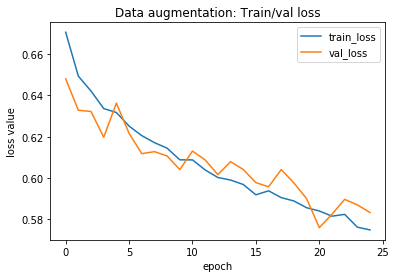

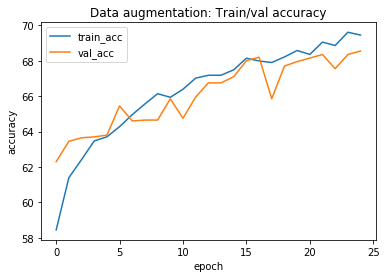

In [25]:
plot(train_losses_da, val_losses_da, train_acc_da, val_acc_da, title='Data augmentation')

In [26]:
val_loss_dataaugmentation, val_accuracy_dataaugmentation = val_losses_da[-1], val_acc_da[-1]
print('Data augmentation. Validation loss: {:.4f}, validation accuracy: {:.4f}'.format(val_loss_dataaugmentation, val_accuracy_dataaugmentation))

Data augmentation. Validation loss: 0.5834, validation accuracy: 68.5500


# L2 regularization / weight decay
We can specify strength of weight decay in optimizer (parameter of optimizer's constructor; https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)

In [43]:
model = MLPModel(32*32*3, 128)
model = model.to(device)
learning_rate = 0.1
### L2 regularization code
alpha = 0.0075 # If too big - the network won't train at all (weights will be zero)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=alpha)
### End
n_epochs = 25
loss_fn = nn.CrossEntropyLoss()

In [44]:
train_losses_wd, val_losses_wd, train_acc_wd, val_acc_wd = train(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_fn)


Epoch 1/25: train_loss: 0.6548, train_accuracy: 60.8391, val_loss: 0.6398, val_accuracy: 62.6000



Epoch 2/25: train_loss: 0.6290, train_accuracy: 64.3957, val_loss: 0.6278, val_accuracy: 64.2500



Epoch 3/25: train_loss: 0.6207, train_accuracy: 65.0087, val_loss: 0.6332, val_accuracy: 64.7500



Epoch 4/25: train_loss: 0.6158, train_accuracy: 65.7435, val_loss: 0.6262, val_accuracy: 64.0000



Epoch 5/25: train_loss: 0.6129, train_accuracy: 66.2130, val_loss: 0.6228, val_accuracy: 66.0000



Epoch 6/25: train_loss: 0.6101, train_accuracy: 66.6391, val_loss: 0.6313, val_accuracy: 63.7000



Epoch 7/25: train_loss: 0.6084, train_accuracy: 66.3217, val_loss: 0.6479, val_accuracy: 63.3500



Epoch 8/25: train_loss: 0.6066, train_accuracy: 66.7522, val_loss: 0.6346, val_accuracy: 65.3500



Epoch 9/25: train_loss: 0.6063, train_accuracy: 66.7870, val_loss: 0.6118, val_accuracy: 66.6500



Epoch 10/25: train_loss: 0.6062, train_accuracy: 66.6391, val_loss: 0.6119, val_accuracy: 65.8500



Epoch 11/25: train_loss: 0.6059, train_accuracy: 66.8000, val_loss: 0.6215, val_accuracy: 64.3000



Epoch 12/25: train_loss: 0.6040, train_accuracy: 67.0609, val_loss: 0.6275, val_accuracy: 66.0000



Epoch 13/25: train_loss: 0.6040, train_accuracy: 66.8391, val_loss: 0.6203, val_accuracy: 65.4500



Epoch 14/25: train_loss: 0.6024, train_accuracy: 67.2913, val_loss: 0.6266, val_accuracy: 63.8000



Epoch 15/25: train_loss: 0.6030, train_accuracy: 66.9217, val_loss: 0.6178, val_accuracy: 65.0500



Epoch 16/25: train_loss: 0.6032, train_accuracy: 67.0435, val_loss: 0.6176, val_accuracy: 65.2000



Epoch 17/25: train_loss: 0.6022, train_accuracy: 66.9783, val_loss: 0.6281, val_accuracy: 64.8000



Epoch 18/25: train_loss: 0.6026, train_accuracy: 67.3174, val_loss: 0.6367, val_accuracy: 64.6000



Epoch 19/25: train_loss: 0.6021, train_accuracy: 67.4435, val_loss: 0.6279, val_accuracy: 65.9000



Epoch 20/25: train_loss: 0.6019, train_accuracy: 67.3870, val_loss: 0.6319, val_accuracy: 63.7000



Epoch 21/25: train_loss: 0.6030, train_accuracy: 66.8783, val_loss: 0.6276, val_accuracy: 64.9500



Epoch 22/25: train_loss: 0.6017, train_accuracy: 67.1696, val_loss: 0.6243, val_accuracy: 65.3500



Epoch 23/25: train_loss: 0.5997, train_accuracy: 67.3478, val_loss: 0.6262, val_accuracy: 65.1000



Epoch 24/25: train_loss: 0.6019, train_accuracy: 67.0739, val_loss: 0.6365, val_accuracy: 64.7500



Epoch 25/25: train_loss: 0.6018, train_accuracy: 67.1130, val_loss: 0.6265, val_accuracy: 64.7000


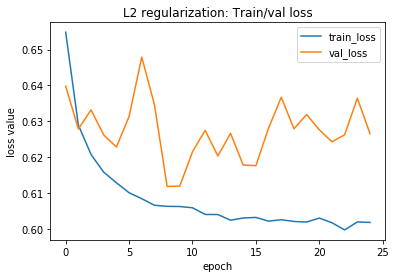

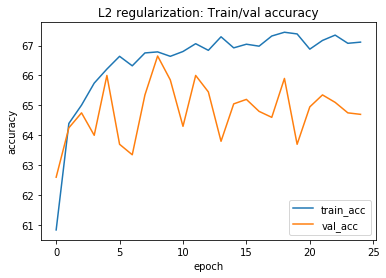

In [45]:
plot(train_losses_wd, val_losses_wd, train_acc_wd, val_acc_wd, title='L2 regularization')

In [46]:
val_loss_weightdecay, val_accuracy_weightdecay = val_losses_wd[-1], val_acc_wd[-1]
print('L2 regularization. Validation loss: {:.4f}, validation accuracy: {:.4f}'.format(val_loss_weightdecay, val_accuracy_weightdecay))

L2 regularization. Validation loss: 0.6265, validation accuracy: 64.7000


# Dropout
We will add dropout layers after every activation function.  
Dropout documentation: https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout

In [31]:
import torch.nn as nn
    
class MLPModelDropout(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, dropout_p=0.5):
        super(MLPModelDropout, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p),  ### Adding dropout layer
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p),  ### Adding dropout layer
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_p),  ### Adding dropout layer
            nn.Linear(hidden_dim, 2)
        )
    
    def forward(self, input):
        input = input.view(input.size(0), -1)
        return self.layers(input)

In [32]:
### MODEL WITH DROPOUT
dropout_p = 0.4
model = MLPModelDropout(32*32*3, 128, dropout_p=dropout_p)
### END
model = model.to(device)
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
n_epochs = 25
loss_fn = nn.CrossEntropyLoss()

In [33]:
train_losses_dropout, val_losses_dropout, train_acc_dropout, val_acc_dropout = train(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_fn)


Epoch 1/25: train_loss: 0.6663, train_accuracy: 59.0174, val_loss: 0.6533, val_accuracy: 62.0500



Epoch 2/25: train_loss: 0.6463, train_accuracy: 62.2087, val_loss: 0.6313, val_accuracy: 62.5000



Epoch 3/25: train_loss: 0.6333, train_accuracy: 63.7261, val_loss: 0.6243, val_accuracy: 63.4500



Epoch 4/25: train_loss: 0.6248, train_accuracy: 64.6130, val_loss: 0.6166, val_accuracy: 65.0000



Epoch 5/25: train_loss: 0.6187, train_accuracy: 65.7609, val_loss: 0.6262, val_accuracy: 62.2500



Epoch 6/25: train_loss: 0.6135, train_accuracy: 66.0130, val_loss: 0.6173, val_accuracy: 65.6000



Epoch 7/25: train_loss: 0.6079, train_accuracy: 66.7913, val_loss: 0.6144, val_accuracy: 65.0500



Epoch 8/25: train_loss: 0.6008, train_accuracy: 67.2826, val_loss: 0.6049, val_accuracy: 67.3000



Epoch 9/25: train_loss: 0.5950, train_accuracy: 68.2435, val_loss: 0.6088, val_accuracy: 66.8500



Epoch 10/25: train_loss: 0.5904, train_accuracy: 68.6000, val_loss: 0.6112, val_accuracy: 65.5500



Epoch 11/25: train_loss: 0.5857, train_accuracy: 68.5783, val_loss: 0.6115, val_accuracy: 66.5000



Epoch 12/25: train_loss: 0.5796, train_accuracy: 69.4652, val_loss: 0.6104, val_accuracy: 66.5500



Epoch 13/25: train_loss: 0.5721, train_accuracy: 69.9217, val_loss: 0.6103, val_accuracy: 65.9500



Epoch 14/25: train_loss: 0.5708, train_accuracy: 70.4174, val_loss: 0.6105, val_accuracy: 65.8500



Epoch 15/25: train_loss: 0.5673, train_accuracy: 70.1609, val_loss: 0.6123, val_accuracy: 66.4000



Epoch 16/25: train_loss: 0.5628, train_accuracy: 70.4130, val_loss: 0.5993, val_accuracy: 67.4500



Epoch 17/25: train_loss: 0.5589, train_accuracy: 71.1130, val_loss: 0.6002, val_accuracy: 68.0000



Epoch 18/25: train_loss: 0.5543, train_accuracy: 71.2913, val_loss: 0.6027, val_accuracy: 67.3000



Epoch 19/25: train_loss: 0.5533, train_accuracy: 71.5652, val_loss: 0.6023, val_accuracy: 67.0000



Epoch 20/25: train_loss: 0.5496, train_accuracy: 71.7043, val_loss: 0.6014, val_accuracy: 66.4500



Epoch 21/25: train_loss: 0.5417, train_accuracy: 72.1217, val_loss: 0.6022, val_accuracy: 67.9500



Epoch 22/25: train_loss: 0.5381, train_accuracy: 72.9217, val_loss: 0.6025, val_accuracy: 67.3500



Epoch 23/25: train_loss: 0.5341, train_accuracy: 72.9304, val_loss: 0.6073, val_accuracy: 68.4500



Epoch 24/25: train_loss: 0.5288, train_accuracy: 73.0087, val_loss: 0.5936, val_accuracy: 67.6500



Epoch 25/25: train_loss: 0.5272, train_accuracy: 73.1783, val_loss: 0.6046, val_accuracy: 68.0500


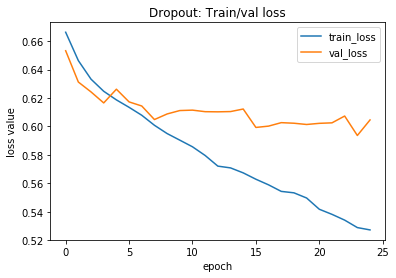

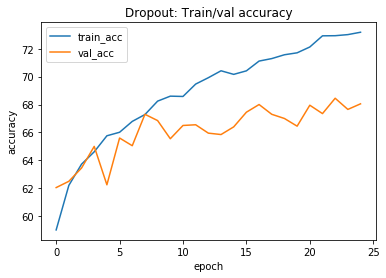

In [34]:
plot(train_losses_dropout, val_losses_dropout, train_acc_dropout, val_acc_dropout, title='Dropout')

In [35]:
val_loss_dropout, val_accuracy_dropout = val_losses_dropout[-1], val_acc_dropout[-1]
print('Dropout. Validation loss: {:.4f}, validation accuracy: {:.4f}'.format(val_loss_dropout, val_accuracy_dropout))

Dropout. Validation loss: 0.6046, validation accuracy: 68.0500


# Results comparison

In [47]:
table_data = [
    ['Regularization type', 'Val Loss', 'Val accuracy'],
    ['No regularization', val_loss_no_regularization, val_accuracy_no_regularization], 
    ['Early stopping', val_loss_early_stopping, val_accuracy_early_stopping],
    ['Data augmentation', val_loss_dataaugmentation, val_accuracy_dataaugmentation],
    ['L2 regularization', val_loss_weightdecay, val_accuracy_weightdecay],
    ['Dropout', val_loss_dropout, val_accuracy_dropout],
]
print("{: >20}| {: >20}| {: >20}".format(*table_data[0]))
print('-'.join(['' for i in range(65)]))
for row in table_data[1:]:
    print("{: >20}| {:20.4f}| {: >20}".format(*row))

 Regularization type|             Val Loss|         Val accuracy
----------------------------------------------------------------
   No regularization|               1.1880|                 66.2
      Early stopping|               0.6042|                67.35
   Data augmentation|               0.5834|                68.55
   L2 regularization|               0.6265|                 64.7
             Dropout|               0.6046|                68.05


In [48]:
loss_curves = [val_losses, val_losses_es, val_losses_da, val_losses_wd, val_losses_dropout]
reg_types = ['no regularization', 'early stopping', 'data augmentation', 'l2 regularization', 'dropout']

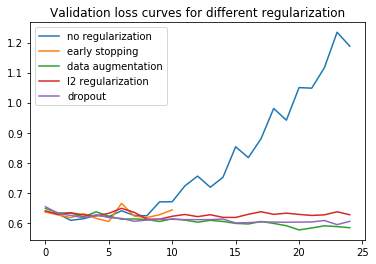

In [49]:
for loss_curve in loss_curves:
    plt.plot(np.arange(len(loss_curve)), loss_curve)
plt.title('Validation loss curves for different regularization')
plt.legend(reg_types);

**Usually we use more than one method for regularization (even all of the above)**